In [302]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import tqdm
import os
import mcbe
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iris

In [303]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

X_3 = X[:,[0,2,3]]

# Scale data to have mean 0 and variance 1 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_3)
#m = np.amax(X_scaled)
#X_ball = X_scaled/m

# Split the data set into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=2)

In [304]:
# size of the first layer
l1 = 6

In [305]:
class Model(nn.Module):
    def __init__(self, input_dim, l1):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, l1)
        #self.layer2 = nn.Linear(20, 10)
        self.layer3 = nn.Linear(l1, 3)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        #x = F.relu(self.layer2(x))
        x = F.softmax(self.layer3(x), dim=1)
        return x

In [306]:
X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()
X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

In [307]:
model     = Model(X_train.shape[1],l1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn   = nn.CrossEntropyLoss() 
model

Model(
  (layer1): Linear(in_features=3, out_features=6, bias=True)
  (layer3): Linear(in_features=6, out_features=3, bias=True)
)

In [308]:
EPOCHS  = 100

weights = []
weights_norm = []
norms = []
biases = np.zeros([EPOCHS + 1,l1])
percent_inj_list = []

w1 = model.layer1.weight
b1 = model.layer1.bias
m1 = w1.shape[0]
n1 = w1.shape[1]
norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
w1_norm = torch.div(w1,norm)
w1_norm[w1_norm == np.inf] = 0

weights.append(w1.detach().numpy())
weights_norm.append(w1_norm.detach().numpy())
norms.append(norm.detach().numpy())
biases[0,:] = b1.detach().numpy()

#epoch counter
k = 1

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

loss_list_injective     = np.zeros((EPOCHS,))
accuracy_list_injective = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    w1 = model.layer1.weight
    b1 = model.layer1.bias

    print("check inj")
    # check injectivity 
    percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test[:1000,:],iter=X_test[:1000,:].shape[0])
    percent_inj_list.append(percent_inj)
    print("percent_inj: ", percent_inj)


    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0
    
    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[k,:] = b1.detach().numpy()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()
    
    

    
    k = k+1

accuracy_list

100%|██████████| 100/100 [00:00<00:00, 284.04it/s]


array([0.26666668, 0.26666668, 0.26666668, 0.30000001, 0.73333335,
       0.73333335, 0.76666665, 0.93333334, 0.96666664, 0.93333334,
       0.86666667, 0.83333331, 0.83333331, 0.83333331, 0.83333331,
       0.83333331, 0.83333331, 0.83333331, 0.89999998, 0.89999998,
       0.93333334, 0.96666664, 0.96666664, 0.96666664, 1.        ,
       1.        , 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666664,
       0.96666664, 0.96666664, 0.96666664, 0.96666664, 0.96666

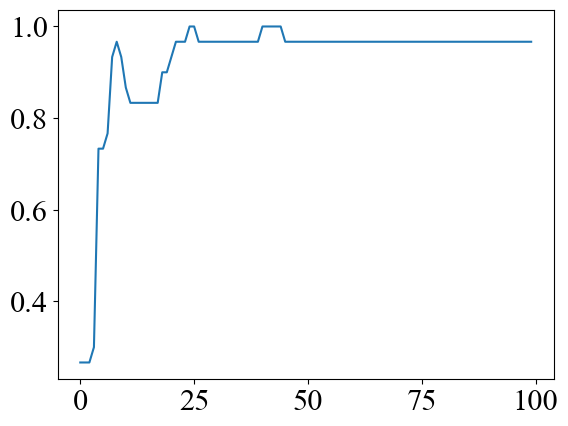

In [309]:
plt.plot(accuracy_list)

# mean over multiple trainings

In [310]:
num_iter = 25
percent_inj2 = []
redundancy = 2

In [311]:
for i in tqdm.trange(num_iter):
    
    # size of the first layer
    l1 = 3*redundancy

    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn   = nn.CrossEntropyLoss() 

    EPOCHS  = 50

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1

    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w1 = model.layer1.weight
        b1 = model.layer1.bias

        # check injectivity 
        percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test,iter=X_test.shape[0])
        percent_inj_list.append(percent_inj)


        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
        
        

        
        k = k+1

    percent_inj2.append(percent_inj_list)


    

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


In [312]:
percent_inj3 = []
redundancy = 3

In [313]:
for i in tqdm.trange(num_iter):
    
    # size of the first layer
    l1 = 3*redundancy

    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn   = nn.CrossEntropyLoss() 

    EPOCHS  = 50

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1

    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w1 = model.layer1.weight
        b1 = model.layer1.bias

        # check injectivity 
        percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test,iter=X_test.shape[0])
        percent_inj_list.append(percent_inj)


        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
        
        

        
        k = k+1

    percent_inj3.append(percent_inj_list)

100%|██████████| 25/25 [00:11<00:00,  2.09it/s]


In [314]:
percent_inj9 = []
redundancy = 9

In [315]:
for i in tqdm.trange(num_iter):
    
    # size of the first layer
    l1 = 3*redundancy

    model     = Model(X_train.shape[1],l1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    loss_fn   = nn.CrossEntropyLoss() 

    EPOCHS  = 50

    weights = []
    weights_norm = []
    norms = []
    biases = np.zeros([EPOCHS + 1,l1])
    percent_inj_list = []

    w1 = model.layer1.weight
    b1 = model.layer1.bias
    m1 = w1.shape[0]
    n1 = w1.shape[1]
    norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
    w1_norm = torch.div(w1,norm)
    w1_norm[w1_norm == np.inf] = 0

    weights.append(w1.detach().numpy())
    weights_norm.append(w1_norm.detach().numpy())
    norms.append(norm.detach().numpy())
    biases[0,:] = b1.detach().numpy()

    #epoch counter
    k = 1

    loss_list     = np.zeros((EPOCHS,))
    accuracy_list = np.zeros((EPOCHS,))

    for epoch in range(EPOCHS):
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        w1 = model.layer1.weight
        b1 = model.layer1.bias

        # check injectivity 
        percent_inj = mcbe.check_injectivity_naive(w1.detach().numpy(),b1.detach().numpy(),points=X_test,iter=X_test.shape[0])
        percent_inj_list.append(percent_inj)


        norm = w1.pow(2).sum(keepdim=True,dim=1).sqrt()
        w1_norm = torch.div(w1,norm)
        w1_norm[w1_norm == np.inf] = 0
        
        weights.append(w1.detach().numpy())
        weights_norm.append(w1_norm.detach().numpy())
        norms.append(norm.detach().numpy())
        biases[k,:] = b1.detach().numpy()
        
        with torch.no_grad():
            y_pred = model(X_test)
            correct = (torch.argmax(y_pred, dim=1) == y_test).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
        
        

        
        k = k+1

    percent_inj9.append(percent_inj_list)

100%|██████████| 25/25 [00:11<00:00,  2.18it/s]


In [316]:
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 22})

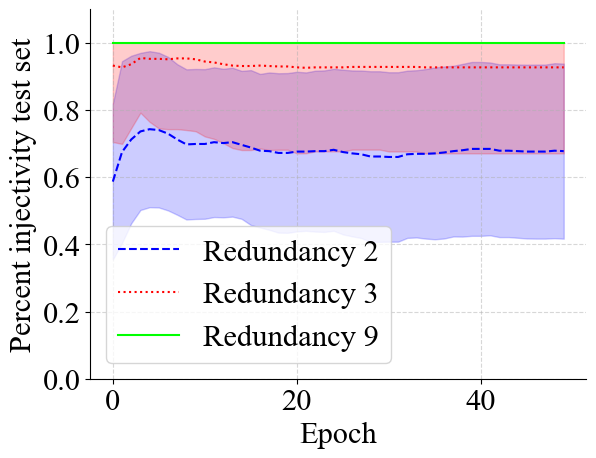

In [319]:
mean_inj2 = np.mean(percent_inj2,axis=0)
std_inj2 = np.std(percent_inj2,axis=0)
mean_inj3 = np.mean(percent_inj3,axis=0)
std_inj3 = np.std(percent_inj3,axis=0)
mean_inj9 = np.mean(percent_inj9,axis=0)
std_inj9 = np.std(percent_inj9,axis=0)
plt.plot(mean_inj2,label='Redundancy 2',color="blue",linestyle="--")
plt.fill_between(range(EPOCHS),mean_inj2-std_inj2,mean_inj2+std_inj2,alpha=0.2,color = "blue")
plt.plot(mean_inj3,label='Redundancy 3',color="red",linestyle=":")
#plt.fill_between(range(EPOCHS),mean_inj3-std_inj3,mean_inj3+std_inj3,alpha=0.2,color="red")
#plot std under 1
plt.fill_between(range(EPOCHS),1-2*std_inj3,1,alpha=0.2,color="red")
plt.plot(mean_inj9,label='Redundancy 9',color = "lime")
plt.fill_between(range(EPOCHS),mean_inj9-std_inj9,mean_inj9+std_inj9,alpha=0.2)
plt.xlabel('Epoch')
plt.ylabel('Percent injectivity test set')
plt.ylim([0,1.1])
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(linestyle='--', alpha=0.5)